In [1]:
import os
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import heapq
import pandas as pd

C:\Users\assas\AppData\Local\Temp\ipykernel_14820\846880267.py:6: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
img = cv.imread('../../../data/FracAtlas/images/Fractured/IMG0000844.jpg')
gray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
dns = cv.fastNlMeansDenoising(gray, None, 7, 21)
clahe = cv.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
cl1 = clahe.apply(dns)

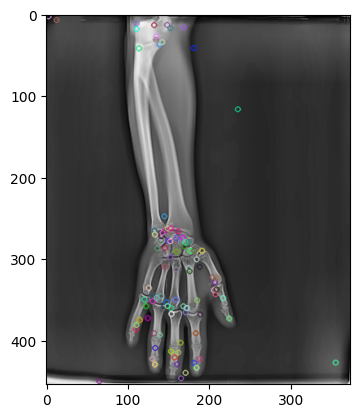

In [3]:
sift = cv.SIFT_create()
kp = sift.detect(cl1,None)

img=cv.drawKeypoints(cl1,kp,img)
plt.imshow(img)

In [12]:
def load_images_from_folder(folder, image_files):
    images = {}
    for filename in os.listdir(folder):
        category = []
        path = folder + "/" + filename
        for cat in os.listdir(path):
            if cat in image_files:
                img = cv.imread(path + "/" + cat)
                if img is not None:
                    category.append((cat, img))
        images[filename] = category
    return images

In [13]:
def sift_features(images):
    descriptor_list = []
    sift = cv.SIFT_create()
    for key,value in images.items():
        for cat, img in value:
            kp, des = sift.detectAndCompute(img,None)
            descriptor_list.append((cat, des))

    descriptors=descriptor_list[0][1]
    for image_path,descriptor in descriptor_list[1:]:
        descriptors=np.vstack((descriptors,descriptor))
    return descriptors, descriptor_list

In [14]:
import pickle as pkl

with open("../../../method-2/process-featureext/test-train-dataset/train.pkl", "rb") as train_file:
    [X_train, y_train] = pkl.load(train_file)

with open("../../../method-2/process-featureext/test-train-dataset/test.pkl", "rb") as test_file:
    [X_test, y_test] = pkl.load(test_file)

In [15]:
dir = '../../../data/FracAtlas/images'
train_image_files = X_train['image_id'].values
test_image_files = X_test['image_id'].values

In [17]:
from scipy.cluster.vq import kmeans,vq

train_images = load_images_from_folder(dir, train_image_files)

descriptors, descriptor_list = sift_features(train_images)
k=200
voc,variance=kmeans(descriptors.astype(float),k,1)

im_features=np.zeros((len(train_image_files),k),"float32")
for i in range(len(train_image_files)):
    words,distance=vq(descriptor_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1


In [18]:
from sklearn.preprocessing import StandardScaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

In [43]:
train = pd.DataFrame(X_train)[["image_id", "hand", "leg", "hip", "shoulder", "mixed"]].assign(label=y_train)
train

,image_id,hand,leg,hip,shoulder,mixed,label
373,IMG0000375.jpg,0,1,0,0,0,0
3823,IMG0003873.jpg,1,0,0,1,1,0
2762,IMG0002796.jpg,0,1,0,0,0,0
3659,IMG0003700.jpg,1,0,0,0,0,0
3351,IMG0003388.jpg,0,1,0,0,0,0
...,...,...,...,...,...,...,...
1176,IMG0001188.jpg,0,1,0,0,0,0
1437,IMG0001452.jpg,0,1,0,0,0,0
1169,IMG0001181.jpg,0,1,0,0,0,0
1677,IMG0001696.jpg,0,0,1,0,0,0


In [39]:
feature_df = pd.DataFrame(im_features).assign(image_id = list(zip(*descriptor_list))[0])
feature_df

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,image_id
0,0.030955,0.088609,0.003784,-0.214704,-0.074425,-0.191240,-0.261250,0.383025,0.065426,-0.057732,...,0.395437,0.573746,-0.209752,0.353557,0.029783,1.186223,0.139865,-0.090127,0.017050,IMG0000025.jpg
1,3.314303,0.838340,2.805354,2.245011,0.812163,2.585629,2.295065,2.058629,2.002103,2.301039,...,1.896928,2.225448,0.935816,2.212504,4.330933,4.639448,2.610009,2.003200,1.336589,IMG0000044.jpg
2,0.851792,0.088609,2.310959,1.220130,0.221104,1.762853,0.590855,1.460199,0.581873,0.384537,...,1.467930,0.986672,0.772164,0.353557,2.676644,0.244434,0.316304,2.003200,0.544866,IMG0000057.jpg
3,1.946241,0.538448,5.771721,3.474869,1.846516,4.334028,2.863135,3.135803,2.131215,1.858770,...,2.111426,3.257761,1.426774,3.141978,4.992648,3.226765,2.610009,2.808326,1.600497,IMG0000058.jpg
4,6.460845,4.586998,4.618134,10.239085,4.358516,4.128334,5.419450,4.332664,4.584341,5.691774,...,7.259395,6.561164,4.699825,6.859873,4.992648,6.052131,6.491663,5.867804,2.392221,IMG0000059.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,-0.242657,-0.211284,-0.325812,-0.214704,-0.222190,-0.294087,-0.261250,-0.215406,-0.192798,-0.205156,...,-0.248059,-0.252104,-0.209752,-0.266092,0.360641,-0.226460,-0.213012,-0.251152,-0.246858,IMG0004371.jpg
3262,-0.242657,0.088609,-0.161014,-0.214704,-0.222190,-0.294087,-0.261250,-0.215406,-0.192798,-0.205156,...,-0.033561,-0.252104,-0.209752,-0.266092,0.029783,-0.226460,-0.036574,-0.251152,-0.246858,IMG0004372.jpg
3263,-0.242657,-0.211284,-0.161014,-0.214704,-0.222190,0.014454,-0.261250,-0.215406,-0.192798,-0.205156,...,-0.033561,-0.252104,-0.209752,0.043732,-0.301074,-0.226460,-0.213012,-0.251152,0.017050,IMG0004383.jpg
3264,-0.242657,-0.211284,-0.325812,-0.214704,-0.222190,-0.191240,-0.261250,-0.215406,-0.192798,-0.205156,...,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.226460,-0.213012,-0.251152,-0.246858,IMG0004388.jpg


In [44]:
train = pd.merge(train, feature_df, on="image_id")
X_train = train.drop(columns=["image_id", "label"])
y_train = train["label"]

In [48]:
from sklearn.svm import LinearSVC
clf=LinearSVC()
clf.fit(X_train.values,y_train.values)

c:\Users\assas\anaconda3\envs\opencv\lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
c:\Users\assas\anaconda3\envs\opencv\lib\site-packages\sklearn\svm\_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [49]:
test_images = load_images_from_folder(dir, test_image_files)

descriptors_test, descriptor_list_test = sift_features(test_images)

test_features=np.zeros((len(test_image_files),k),"float32")
for i in range(len(test_image_files)):
    words,distance=vq(descriptor_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1

In [50]:
test_features=stdslr.transform(test_features)

In [51]:
test = pd.DataFrame(X_test)[["image_id", "hand", "leg", "hip", "shoulder", "mixed"]].assign(label=y_test)
test

,image_id,hand,leg,hip,shoulder,mixed,label
2511,IMG0002542.jpg,0,1,1,0,1,1
3338,IMG0003375.jpg,1,0,0,0,0,0
1404,IMG0001418.jpg,0,1,0,0,0,0
953,IMG0000963.jpg,1,0,0,1,1,0
3023,IMG0003057.jpg,0,1,0,0,0,0
...,...,...,...,...,...,...,...
2841,IMG0002875.jpg,1,0,0,0,0,0
3536,IMG0003577.jpg,1,0,0,0,0,0
765,IMG0000774.jpg,0,1,0,0,0,0
1541,IMG0001556.jpg,0,1,0,0,0,0


In [52]:
test_feature_df = pd.DataFrame(test_features).assign(image_id = list(zip(*descriptor_list_test))[0])
test_feature_df

,0,1,2,3,4,5,6,7,8,9,...,191,192,193,194,195,196,197,198,199,image_id
0,21.783136,8.485603,12.528446,7.369418,12.485573,3.511252,9.964009,10.316966,6.133683,8.050547,...,13.479857,13.167971,8.463834,9.648293,12.271517,7.935708,8.079612,12.630860,7.934287,IMG0000019.jpg
1,1.125404,5.186784,2.146161,3.474869,2.585339,3.099864,1.726995,0.861769,4.067893,4.070118,...,4.470912,2.225448,3.881562,3.141978,4.330933,4.796412,5.080152,2.003200,5.031300,IMG0000155.jpg
2,5.503201,1.438126,1.486968,0.810177,2.289810,0.837230,3.999275,1.819257,1.485656,0.531960,...,1.467930,0.780209,1.426774,3.451802,1.022356,2.284976,1.904253,1.842175,1.336589,IMG0000207.jpg
3,1.672629,4.137160,2.970152,2.654963,1.994280,5.362497,3.431205,0.383025,2.260327,3.185579,...,5.972403,2.225448,4.208867,4.691101,0.691499,2.598906,5.962346,2.325251,2.656129,IMG0000261.jpg
4,-0.242657,-0.211284,-0.325812,-0.214704,-0.222190,0.631536,0.022785,-0.095720,-0.192798,-0.205156,...,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.226460,-0.213012,-0.251152,-0.246858,IMG0000307.jpg
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,-0.242657,-0.211284,-0.325812,-0.214704,-0.222190,-0.294087,-0.261250,-0.215406,-0.192798,-0.205156,...,-0.033561,-0.252104,-0.209752,-0.266092,-0.301074,-0.226460,-0.213012,-0.251152,-0.246858,IMG0004284.jpg
813,-0.242657,-0.211284,-0.161014,-0.214704,-0.222190,-0.191240,0.022785,-0.095720,-0.192798,-0.205156,...,-0.248059,-0.045642,-0.209752,0.043732,0.029783,-0.069495,-0.213012,-0.251152,1.864405,IMG0004285.jpg
814,-0.242657,-0.211284,-0.161014,-0.214704,-0.222190,-0.088393,-0.261250,-0.215406,-0.192798,-0.205156,...,-0.248059,-0.045642,-0.209752,-0.266092,0.029783,-0.226460,-0.036574,-0.251152,-0.246858,IMG0004288.jpg
815,-0.242657,-0.211284,-0.161014,-0.214704,-0.222190,-0.294087,-0.261250,-0.215406,-0.192798,-0.205156,...,-0.033561,-0.252104,-0.046099,-0.266092,0.029783,-0.226460,-0.213012,-0.251152,-0.246858,IMG0004299.jpg


In [53]:
test = pd.merge(test, test_feature_df, on="image_id")
X_test = test.drop(columns=["image_id", "label"])
y_test = test["label"]

In [58]:
from sklearn.metrics import confusion_matrix,accuracy_score, classification_report

prediction = clf.predict(X_test.values)
accuracy=accuracy_score(y_test,prediction)
print(classification_report(y_test,prediction))

              precision    recall  f1-score   support

           0       0.85      0.97      0.91       674
           1       0.57      0.22      0.31       143

    accuracy                           0.83       817
   macro avg       0.71      0.59      0.61       817
weighted avg       0.80      0.83      0.80       817



In [65]:
train

,image_id,hand,leg,hip,shoulder,mixed,label,0,1,2,...,190,191,192,193,194,195,196,197,198,199
0,IMG0000375.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,-0.248059,-0.045642,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,-0.246858
1,IMG0003873.jpg,1,0,0,1,1,0,-0.242657,-0.211284,-0.161014,...,-0.206691,-0.033561,-0.045642,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.090127,-0.246858
2,IMG0002796.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,0.180938,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,0.017050
3,IMG0003700.jpg,1,0,0,0,0,0,-0.242657,-0.211284,-0.161014,...,-0.094276,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,-0.246858
4,IMG0003388.jpg,0,1,0,0,0,0,-0.242657,-0.211284,0.003784,...,-0.094276,-0.033561,-0.252104,-0.209752,0.043732,-0.301074,-0.22646,-0.213012,-0.090127,-0.246858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3261,IMG0001188.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,-0.246858
3262,IMG0001452.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.161014,...,-0.206691,-0.248059,-0.252104,-0.209752,0.043732,-0.301074,-0.22646,-0.213012,-0.251152,0.017050
3263,IMG0001181.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.036574,-0.251152,-0.246858
3264,IMG0001696.jpg,0,0,1,0,0,0,-0.242657,0.088609,0.168583,...,-0.206691,-0.033561,-0.252104,-0.209752,0.043732,0.029783,-0.22646,-0.213012,-0.251152,-0.246858


In [66]:
test

,image_id,hand,leg,hip,shoulder,mixed,label,0,1,2,...,190,191,192,193,194,195,196,197,198,199
0,IMG0002542.jpg,0,1,1,0,1,1,0.167761,-0.211284,0.168583,...,-0.206691,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.090127,-0.246858
1,IMG0003375.jpg,1,0,0,0,0,0,-0.242657,-0.211284,-0.325812,...,0.130554,-0.248059,-0.252104,-0.046099,-0.266092,0.360641,-0.22646,-0.213012,-0.251152,-0.246858
2,IMG0001418.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,-0.246858
3,IMG0000963.jpg,1,0,0,1,1,0,-0.105851,-0.211284,0.168583,...,-0.206691,-0.248059,-0.252104,-0.209752,0.043732,-0.301074,-0.22646,-0.213012,0.231924,-0.246858
4,IMG0003057.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.161014,...,-0.206691,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.090127,-0.246858
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,IMG0002875.jpg,1,0,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,-0.248059,-0.252104,-0.046099,-0.266092,-0.301074,-0.22646,-0.213012,-0.090127,-0.246858
813,IMG0003577.jpg,1,0,0,0,0,0,-0.242657,-0.211284,-0.161014,...,0.242970,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,-0.246858
814,IMG0000774.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,-0.248059,-0.252104,-0.209752,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,-0.246858
815,IMG0001556.jpg,0,1,0,0,0,0,-0.242657,-0.211284,-0.325812,...,-0.206691,-0.033561,-0.045642,-0.046099,-0.266092,-0.301074,-0.22646,-0.213012,-0.251152,-0.246858


In [67]:
train.to_csv("train.csv", index=False)
test.to_csv("test.csv", index=False)